7. Kaggle1_Topic Modeling
•	LDA Topic Modeling on Data1 toddler


- Soo Kyung Bae(Scarlett), Ph.D. Student
- Dept. of Integrated Medicine(Major in Digital Healthcare)
- Yonsei University College of Medicine

In [3]:
## Import Data

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# import pandas as pd

# Convert the column names to a DataFrame and save to CSV :/home/skbae/Documents/skbae/ASD/paper/Pgm/Final/T_ASD_Toddler_feb2024.csv
# pd.DataFrame(T_ASD2).to_csv('./T_ASD_Toddler_feb2024.csv', header=True, index=False)

In [4]:
os.getcwd()

'/home/skbae/Documents/skbae/ASD/paper/Pgm/Final'

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
T_ASD2 = pd.read_csv('./T_ASD_Toddler_feb2024.csv')

In [ ]:
#3.  Tokenize words and clean up the text

In [6]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

/home/skbae/anaconda3/envs/myNLP/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/home/skbae/anaconda3/envs/myNLP/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-02-22 16:09:38.666669: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 16:09:38.719812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 16:09:39.394227: W tensorflo

In [7]:
data = T_ASD2.combined.values.tolist() 

In [8]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['social', 'interaction', 'impairment', 'in', 'social', 'emotional', 'reciprocity', 'absent', 'speech', 'play', 'impairment', 'stares', 'blankly', 'at', 'play', 'objects', 'rather', 'than', 'manipulating', 'them']]


In [ ]:
#4.Creating Bigram and Trigram models

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['social', 'interaction', 'impairment', 'in', 'social', 'emotional', 'reciprocity', 'absent', 'speech', 'play', 'impairment', 'stares', 'blankly', 'at', 'play', 'objects', 'rather', 'than', 'manipulating', 'them']


In [ ]:
#5. Remove Stopwords, make bigrams and lemmatize

In [31]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
#6. Call the functions in order

In [ ]:
#7. Create Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words)  
# # wiithout lemmatized
#id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words  # data_words_bigrams
# build the corpus i.e. vectors with the number of occurence of each word per note
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [11]:
T_ASD2['Class/ASD Traits '].value_counts()

Yes    728
No     326
Name: Class/ASD Traits , dtype: int64

In [34]:
728+ 326

1054

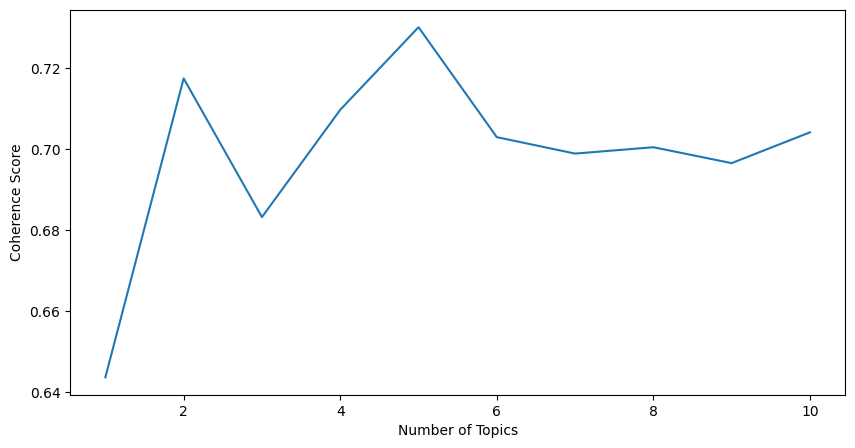

In [68]:
# build a dictionary where for each tweet, each word has its own id.
# # We have 6882 tweets and 10893 words in the dictionary.
#tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)
# build the corpus i.e. vectors with the number of occurence of each word per tweet
#tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]
# compute coherence
t_coherence = []
for nb_topics in range(1,11):    
    #lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10) 
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = nb_topics,#num_topics=20, 
                                           random_state= 10, # 100 - 10-1
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)   
    cohm = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    #cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')    
    coh = cohm.get_coherence()    
    t_coherence.append(coh)
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,11),t_coherence) #36
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [ ]:
# Topic Modeling

In [35]:
#k=5
lda_model_5_0 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [36]:
# 9. # Print the keyword of topics :lda_model_4_0 : k=4
pprint(lda_model_5_0.print_topics(num_words=10))
doc_lda_5_0 = lda_model_5_0[corpus]

[(0,
  '0.314*"speech" + 0.314*"absent" + 0.090*"pretend" + 0.090*"does" + '
  '0.055*"play" + 0.033*"shifting" + 0.028*"attention" + 0.028*"eye" + '
  '0.028*"contacts" + 0.009*"spontaneously"'),
 (1,
  '0.146*"pointing" + 0.085*"interest" + 0.085*"express" + 0.085*"to" + '
  '0.071*"social" + 0.061*"spontaneously" + 0.041*"difficulty" + '
  '0.041*"gesture" + 0.041*"imitating" + 0.036*"reciprocity"'),
 (2,
  '0.158*"play" + 0.093*"impairment" + 0.078*"manipulating" + 0.078*"at" + '
  '0.078*"stares" + 0.078*"rather" + 0.078*"objects" + 0.078*"than" + '
  '0.078*"them" + 0.078*"blankly"'),
 (3,
  '0.126*"attention" + 0.112*"social" + 0.088*"and" + 0.088*"deficit" + '
  '0.088*"concentration" + 0.059*"impairment" + 0.056*"reciprocity" + '
  '0.056*"emotional" + 0.056*"interaction" + 0.056*"in"'),
 (4,
  '0.072*"attention" + 0.059*"social" + 0.056*"pointing" + 0.051*"gesture" + '
  '0.051*"difficulty" + 0.051*"imitating" + 0.039*"absent" + 0.039*"speech" + '
  '0.037*"pretend" + 0.037*"

In [ ]:
#10. Evaluate topic models

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_5_0.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_5_0 = CoherenceModel(model=lda_model_5_0, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda_5_0 = coherence_model_lda_5_0.get_coherence()
print('\nCoherence Score: ', coherence_lda_5_0)


Perplexity:  -3.463192340563126

Coherence Score:  0.7929938531155167


In [ ]:
#11. Visualize the topic model

In [38]:
#lda_model_4_0
# Visualize the topics
pyLDAvis.enable_notebook()
vis5_0 = pyLDAvis.gensim.prepare(lda_model_5_0, corpus, id2word)
vis5_0

/home/skbae/anaconda3/envs/myNLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.315105  0.171058       1        1  34.121882
4      0.090124 -0.097261       2        1  29.459887
1     -0.003695 -0.197084       3        1  16.745410
3     -0.040601 -0.092748       4        1  16.687145
0      0.269277  0.216035       5        1   2.985677, topic_info=           Term        Freq        Total Category  logprob  loglift
0        absent  485.000000   485.000000  Default   30.000  30.0000
13       speech  485.000000   485.000000  Default   29.000  29.0000
30     pointing  961.000000   961.000000  Default   28.000  28.0000
31      pretend  551.000000   551.000000  Default   27.000  27.0000
25         does  551.000000   551.000000  Default   26.000  26.0000
..          ...         ...          ...      ...      ...      ...
5            in    0.197385   694.950037   Topic5   -8.168  -4.6551
6   interaction    0.197385   694.950037   Topic5   -8.168  -4.6551
11  reciprocity    0.197385   694.950037   Topic5   -8.168  -4.6551
4    impairment    0.197573  1311.480785   Topic5   -8.167  -5.2892
12       social    0.197380  1388.917819   Topic5   -8.168  -5.3476

[194 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         2  0.548165  absent
0         5  0.449248  absent
17        2  0.421907     and
17        4  0.577169     and
1         1  0.998655      at
...     ...       ...     ...
14        1  0.998655  stares
15        1  0.998655    than
16        1  0.998655    them
33        2  0.380044      to
33        3  0.618503      to

[91 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

In [ ]:
# Save the model

In [39]:
from joblib import dump

# Assuming that lda is your trained model
dump(lda_model_5_0 , './lda_model_5_0.joblib') 

['./lda_model_5_0.joblib']

In [ ]:
# load the model

In [40]:
from joblib import load

lda_model_5_0 = load('./lda_model_5_0.joblib') 

In [ ]:
#12. #Assinging the topics to the document

In [41]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
# vis5_0 = pyLDAvis.gensim.prepare(lda_model_5_0, corpus, id2word)

In [42]:
#2. 5 topics
df_topic_sents_keywords_5tp = format_topics_sentences(ldamodel=lda_model_5_0, corpus=corpus, texts=data_words  )

# Format
df_dominant_topic_5tp = df_topic_sents_keywords_5tp.reset_index()
df_dominant_topic_5tp.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_5tp.head(5)

/tmp/ipykernel_60920/731305557.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_60920/731305557.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.8787,"play, impairment, manipulating, at, stares, ra...","[social, interaction, impairment, in, social, ..."
1,1,3,0.9653,"attention, social, and, deficit, concentration...","[attention, and, concentration, deficit, conta..."
2,2,2,0.5417,"play, impairment, manipulating, at, stares, ra...","[attention, and, concentration, deficit, socia..."
3,3,4,0.6718,"attention, social, pointing, gesture, difficul...","[attention, and, concentration, deficit, conta..."
4,4,4,0.6477,"attention, social, pointing, gesture, difficul...","[attention, and, concentration, deficit, conta..."


In [45]:
len(df_dominant_topic_5tp)

1054

In [37]:
# 5 topics
T_ASD_topics_5tp = pd.concat([df_dominant_topic_5tp, T_ASD], axis=1)


In [38]:
T_ASD.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A2_C0870532,A3_C4036288,A4_C0424091,A5_C2371970,A6_C2370875,A7_C4064035,A8_C1854882,A9_C0566243,A10_C4064319,combined
0,1,0,0,0,0,0,0,1,1,0,...,,,,,,social interaction impairment in social/emotio...,absent speech,,play impairment stares blankly at play objects...,", , , , , ,social interaction impairment in s..."
1,2,1,1,0,0,0,1,1,0,0,...,contacts eye,,,,shifting attention,social interaction impairment in social/emotio...,,,,"attention and concentration deficit ,contacts ..."
2,3,1,0,0,0,0,0,1,1,0,...,,,,,,social interaction impairment in social/emotio...,absent speech,,play impairment stares blankly at play objects...,"attention and concentration deficit , , , , , ..."
3,4,1,1,1,1,1,1,1,1,1,...,contacts eye,spontaneously pointing,pointing to express interest,does pretend play,shifting attention,social interaction impairment in social/emotio...,absent speech,difficulty imitating gesture,play impairment stares blankly at play objects...,"attention and concentration deficit ,contacts ..."
4,5,1,1,0,1,1,1,1,1,1,...,contacts eye,,pointing to express interest,does pretend play,shifting attention,social interaction impairment in social/emotio...,absent speech,difficulty imitating gesture,play impairment stares blankly at play objects...,"attention and concentration deficit ,contacts ..."


In [39]:
T_ASD.columns

Index(['Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits ',
       'A1_C2977673', 'A2_C0870532', 'A3_C4036288', 'A4_C0424091',
       'A5_C2371970', 'A6_C2370875', 'A7_C4064035', 'A8_C1854882',
       'A9_C0566243', 'A10_C4064319', 'combined'],
      dtype='object')

In [40]:
T_ASD['Class/ASD Traits '].value_counts()

Yes    728
No     326
Name: Class/ASD Traits , dtype: int64

In [108]:
T_ASD_topics_5tp.columns

Index(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text', 'Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10', 'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits ',
       'A1_C2977673', 'A2_C0870532', 'A3_C4036288', 'A4_C0424091',
       'A5_C2371970', 'A6_C2370875', 'A7_C4064035', 'A8_C1854882',
       'A9_C0566243', 'A10_C4064319', 'combined'],
      dtype='object')

In [41]:
df=T_ASD[['Class/ASD Traits ','combined']]

In [42]:
df.head()

,Class/ASD Traits,combined
0,No,", , , , , ,social interaction impairment in s..."
1,Yes,"attention and concentration deficit ,contacts ..."
2,Yes,"attention and concentration deficit , , , , , ..."
3,Yes,"attention and concentration deficit ,contacts ..."
4,Yes,"attention and concentration deficit ,contacts ..."


In [43]:
df.columns =['Class/ASD Traits ','text']

In [44]:
df.head()

,Class/ASD Traits,text
0,No,", , , , , ,social interaction impairment in s..."
1,Yes,"attention and concentration deficit ,contacts ..."
2,Yes,"attention and concentration deficit , , , , , ..."
3,Yes,"attention and concentration deficit ,contacts ..."
4,Yes,"attention and concentration deficit ,contacts ..."


In [ ]:
# Assigning topics to the document

In [79]:
T_ASD_topics_5tp.Dominant_Topic.value_counts()

2    428
4    297
1    177
3    133
0     19
Name: Dominant_Topic, dtype: int64

In [80]:
T_ASD_topics_5tp.columns

Index(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text', 'Case_No', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10', 'Age_Mons', 'Qchat-10-Score', 'Sex', 'Ethnicity', 'Jaundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD Traits ',
       'A1_C2977673', 'A2_C0870532', 'A3_C4036288', 'A4_C0424091',
       'A5_C2371970', 'A6_C2370875', 'A7_C4064035', 'A8_C1854882',
       'A9_C0566243', 'A10_C4064319', 'combined'],
      dtype='object')

In [95]:
T_ASD_topics_5tp['Family_mem_with_ASD'].value_counts()

no     884
yes    170
Name: Family_mem_with_ASD, dtype: int64

In [85]:
#Class/ASD Traits Vs topic comparison

table_5tp = pd.pivot_table(T_ASD_topics_5tp, values='Case_No', index=['Dominant_Topic','Keywords'],
                       columns=['Class/ASD Traits '], aggfunc=len)

In [86]:
table_5tp

,Class/ASD Traits,No,Yes
Dominant_Topic,Keywords,,
0,"speech, absent, pretend, does, play, shifting, attention, eye, contacts, spontaneously",19.0,NaN
1,"pointing, interest, express, to, social, spontaneously, difficulty, gesture, imitating, reciprocity",33.0,144.0
2,"play, impairment, manipulating, at, stares, rather, objects, than, them, blankly",202.0,226.0
3,"attention, social, and, deficit, concentration, impairment, reciprocity, emotional, interaction, in",61.0,72.0
4,"attention, social, pointing, gesture, difficulty, imitating, absent, speech, pretend, does",11.0,286.0


In [89]:
table_5tp_Age_Mons = pd.pivot_table(T_ASD_topics_5tp, values='Case_No', index=['Dominant_Topic','Keywords'],
                       columns=['Age_Mons'], aggfunc=len)

In [90]:
table_5tp_Age_Mons

,Age_Mons,12,13,14,15,16,17,18,19,20,21,...,27,28,29,30,31,32,33,34,35,36
Dominant_Topic,Keywords,,,,,,,,,,,,,,,,,,,,,
0,"speech, absent, pretend, does, play, shifting, attention, eye, contacts, spontaneously",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,2.0,NaN,1.0,NaN,1.0,NaN,10.0
1,"pointing, interest, express, to, social, spontaneously, difficulty, gesture, imitating, reciprocity",12.0,1.0,6.0,7.0,4.0,6.0,5.0,3.0,4.0,3.0,...,1.0,4.0,3.0,13.0,10.0,4.0,5.0,5.0,4.0,46.0
2,"play, impairment, manipulating, at, stares, rather, objects, than, them, blankly",35.0,11.0,6.0,16.0,5.0,2.0,4.0,6.0,9.0,4.0,...,12.0,11.0,7.0,24.0,13.0,14.0,19.0,13.0,14.0,133.0
3,"attention, social, and, deficit, concentration, impairment, reciprocity, emotional, interaction, in",5.0,NaN,3.0,1.0,NaN,3.0,2.0,1.0,NaN,1.0,...,3.0,5.0,3.0,8.0,4.0,5.0,5.0,5.0,2.0,54.0
4,"attention, social, pointing, gesture, difficulty, imitating, absent, speech, pretend, does",15.0,6.0,4.0,7.0,4.0,1.0,5.0,11.0,8.0,5.0,...,7.0,21.0,10.0,20.0,3.0,6.0,7.0,10.0,10.0,77.0


In [91]:
#'Sex'

table_5tp_Sex = pd.pivot_table(T_ASD_topics_5tp, values='Case_No', index=['Dominant_Topic','Keywords'],
                       columns=['Sex'], aggfunc=len)

In [92]:
table_5tp_Sex 

,Sex,f,m
Dominant_Topic,Keywords,,
0,"speech, absent, pretend, does, play, shifting, attention, eye, contacts, spontaneously",8,11
1,"pointing, interest, express, to, social, spontaneously, difficulty, gesture, imitating, reciprocity",54,123
2,"play, impairment, manipulating, at, stares, rather, objects, than, them, blankly",149,279
3,"attention, social, and, deficit, concentration, impairment, reciprocity, emotional, interaction, in",34,99
4,"attention, social, pointing, gesture, difficulty, imitating, absent, speech, pretend, does",74,223


In [ ]:
# Family_mem_with_ASD

In [96]:
table_5tp_Family = pd.pivot_table(T_ASD_topics_5tp, values='Case_No', index=['Dominant_Topic','Keywords'],
                       columns=['Family_mem_with_ASD'], aggfunc=len)

In [97]:
table_5tp_Family

,Family_mem_with_ASD,no,yes
Dominant_Topic,Keywords,,
0,"speech, absent, pretend, does, play, shifting, attention, eye, contacts, spontaneously",17,2
1,"pointing, interest, express, to, social, spontaneously, difficulty, gesture, imitating, reciprocity",155,22
2,"play, impairment, manipulating, at, stares, rather, objects, than, them, blankly",359,69
3,"attention, social, and, deficit, concentration, impairment, reciprocity, emotional, interaction, in",101,32
4,"attention, social, pointing, gesture, difficulty, imitating, absent, speech, pretend, does",252,45


In [ ]:
# "Who completed the test"

In [98]:
table_5tp_who = pd.pivot_table(T_ASD_topics_5tp, values='Case_No', index=['Dominant_Topic','Keywords'],
                       columns=['Who completed the test'], aggfunc=len)

In [99]:
table_5tp_who

,Who completed the test,Health Care Professional,Health care professional,Others,Self,family member
Dominant_Topic,Keywords,,,,,
0,"speech, absent, pretend, does, play, shifting, attention, eye, contacts, spontaneously",NaN,NaN,NaN,NaN,19.0
1,"pointing, interest, express, to, social, spontaneously, difficulty, gesture, imitating, reciprocity",1.0,NaN,NaN,1.0,175.0
2,"play, impairment, manipulating, at, stares, rather, objects, than, them, blankly",7.0,3.0,1.0,2.0,415.0
3,"attention, social, and, deficit, concentration, impairment, reciprocity, emotional, interaction, in",5.0,NaN,1.0,1.0,126.0
4,"attention, social, pointing, gesture, difficulty, imitating, absent, speech, pretend, does",11.0,2.0,1.0,NaN,283.0


In [ ]:
# ChiS- test

In [105]:
#Class/ASD Traits Vs topic comparison

table_5tp_pct = pd.pivot_table(T_ASD_topics_5tp, values='Case_No', index=['Dominant_Topic','Keywords'],
                       columns=['Class/ASD Traits '], aggfunc=sum,
               fill_value=0).apply(lambda x: x*100/sum(x))

In [ ]:
pd.pivot_table(data=df, index='Salesperson',
               columns='Product',
               values='Sales',
               aggfunc=sum,
               fill_value=0).apply(lambda x: x*100/sum(x))

In [106]:
table_5tp_pct

,Class/ASD Traits,No,Yes
Dominant_Topic,Keywords,,
0,"speech, absent, pretend, does, play, shifting, attention, eye, contacts, spontaneously",5.448061,0.000000
1,"pointing, interest, express, to, social, spontaneously, difficulty, gesture, imitating, reciprocity",11.552538,20.841533
2,"play, impairment, manipulating, at, stares, rather, objects, than, them, blankly",59.742555,29.712054
3,"attention, social, and, deficit, concentration, impairment, reciprocity, emotional, interaction, in",18.459578,10.202009
4,"attention, social, pointing, gesture, difficulty, imitating, absent, speech, pretend, does",4.797267,39.244404


In [103]:
import pandas as pd
import scipy.stats as stats

In [107]:
# create contingency table :T_ASD_topics_5tp['Dominant_Topic'],['Class/ASD Traits '],
data_crosstab = pd.crosstab(T_ASD_topics_5tp['Dominant_Topic'],
                            T_ASD_topics_5tp['Class/ASD Traits '],
                           margins=True, margins_name="Total")

In [108]:
data_crosstab 

Class/ASD Traits,No,Yes,Total
Dominant_Topic,,,
0,19,0,19
1,33,144,177
2,202,226,428
3,61,72,133
4,11,286,297
Total,326,728,1054


In [110]:
"""
According to five steps process of hypothesis testing:
H₀: whether Dominant_Topic and their Class/ASD Traits are independent, i.e. no relationship
H₁: whether Dominant_Topic and their their Class/ASD Traits are dependent, i.e. ∃ a relationship
α = 0.05
Following χ2 independence test statistics:


Conclusion: We have enough evidence that there is an association 
between Dominant_Topic and their Class/ASD Traits, at 5% significance level.
"""





''

In [109]:
# significance level
alpha = 0.05

# Calcualtion of Chisquare
chi_square = 0
rows = T_ASD_topics_5tp['Dominant_Topic'].unique()
columns = T_ASD_topics_5tp['Class/ASD Traits '].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 224.88467035209206  and p value is: 0.0
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 224.88467035209206  and critical value is: 9.487729036781154
Null Hypothesis is rejected.
